python 3.13.5

# 1_class_logistic_regression.ipynb

## Data import and test

In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [10]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [11]:
X = data.drop(columns=["DEATH_EVENT", "time"])
X["creatinine_phosphokinase"] = np.log1p(X["creatinine_phosphokinase"])
y = data["DEATH_EVENT"]

## Logistic Regression

### Auxiliary functions

In [12]:
# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Random seed
seed = 42
np.random.seed(seed)
random.seed(seed)

def rocplot(p, y, ax=None, color="C0", label=None):
    """
    Plot the Receiver Operating Characteristic (ROC) curve and compute the AUC.

    Args:
        p (array-like): Predicted probabilities for the positive class.
        y (array-like): True binary class labels (0 or 1).
        ax (matplotlib.axes.Axes, optional): Axis to plot on.
        color (str, optional): Line color.
        label (str, optional): Label for the ROC curve.

    Returns:
        float: AUC
    """
    fpr, tpr, _ = metrics.roc_curve(y, p)
    auc_value = metrics.roc_auc_score(y, p)

    if ax is None:
        ax = plt.gca()

    ax.plot(fpr, tpr, color=color, lw=2, label=f"AUC = {auc_value:.3f}")
    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("False Positive Rate (1 - Specificity)")
    ax.set_ylabel("True Positive Rate (Sensitivity)")
    ax.set_title("ROC Curve")
    ax.grid(True, linestyle="--", alpha=0.5)
    if label or auc_value:
        ax.legend(loc="lower right")

    return auc_value

def confmatplot(y_true, y_pred, ax=None, cmap="Blues"):
    """
    Plot a styled confusion matrix.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        ax (matplotlib.axes.Axes, optional): Axis to plot on.
        cmap (str, optional): Colormap for heatmap.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    acc = 100 * cm.diagonal().sum() / cm.sum()
    err = 100 - acc

    if ax is None:
        ax = plt.gca()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"Confusion Matrix\nAccuracy: {acc:.1f}%, Error: {err:.1f}%")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(np.arange(cm.shape[1]))
    ax.set_yticklabels(np.arange(cm.shape[0]))

    # Add counts in cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                f"{cm[i, j]}",
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10,
            )

    ax.grid(False)


### code

wiht regularization strength

In [15]:
# Parameters
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-3, 3, 50)  # λ search grid
cols = X.columns.tolist()

# Containers
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []
mcc_mean, mcc_std = [] , [] # Containers for MCC

# Helper function for z-score standardization
def standardize_features(X_train_df, X_test_df, cols):
    """Standardize selected columns using train fold statistics."""
    mu = X_train_df[cols].mean(axis=0)
    sigma = X_train_df[cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std = X_train_df.copy()
    X_test_std = X_test_df.copy()

    for X_ in [X_train_std, X_test_std]:
        X_[cols] = X_[cols].astype("float64")
        X_.loc[:, cols] = (X_[cols] - mu) / sigma

    return X_train_std, X_test_std

# K-fold CV across λ values
N_total = len(X)
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []
    fold_mccs = []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize features
        X_train, X_test = standardize_features(X_train, X_test, cols)

        # Fit Logistic Regression with L2 regularization
        model = LogisticRegression(
            penalty="l2",
            C=1/lam,
            solver="lbfgs",
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute classification error
        train_err = 1 - accuracy_score(y_train, y_train_pred)
        test_err = 1 - accuracy_score(y_test, y_test_pred)

        # Compute MCC
        fold_mcc = matthews_corrcoef(y_test, y_test_pred)

        fold_train_errs.append(train_err)
        fold_test_errs.append(test_err)
        fold_weights.append(len(test_idx) / N_total)
        fold_mccs.append(fold_mcc)

    # Aggregate fold metrics
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))
    mcc_mean.append(np.mean(fold_mccs))
    mcc_std.append(np.std(fold_mccs, ddof=1))

# Compile results
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_err_mean": train_err_mean,
    "train_err_std": train_err_std,
    "gen_err_est": gen_err_est,
    "test_err_std": test_err_std,
    "mcc_mean": mcc_mean,
    "mcc_std": mcc_std
})

best_idx = np.argmax(cv_table["mcc_mean"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_mcc = cv_table.loc[best_idx, "mcc_mean"]

# Print Results
print("10-fold CV (Logistic Regression)")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (by MCC): {best_lambda:.6g}")
print(f"Best mean MCC: {best_mcc:.6f}")


10-fold CV (Logistic Regression)
     lambda  train_err_mean  train_err_std  gen_err_est  test_err_std  mcc_mean  mcc_std
   0.001000        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.001326        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.001758        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.002330        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.003089        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.004095        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.005429        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.007197        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.009541        0.240063       0.009885     0.264214      0.088995  0.356105 0.215875
   0.012649        0.240063       0.009885     0.264214      0.088995  0.3561

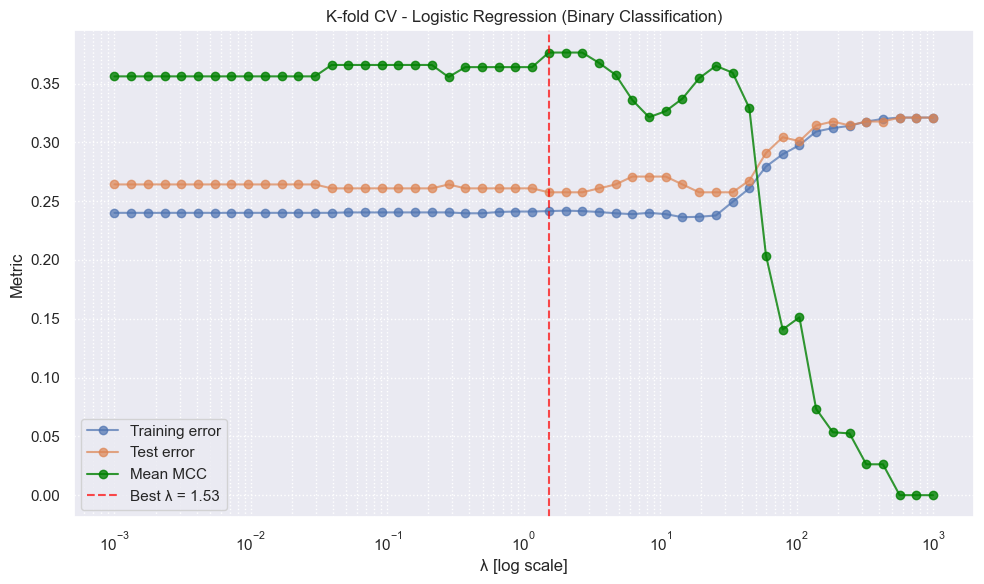

In [16]:
# Plot CV results (Classification error + MCC)
plt.figure(figsize=(10, 6))

# Classification error
plt.semilogx(lambdas, cv_table["train_err_mean"], "o-", label="Training error", alpha=0.7)
plt.semilogx(lambdas, cv_table["gen_err_est"], "o-", label="Test error", alpha=0.7)

# MCC
plt.semilogx(lambdas, cv_table["mcc_mean"], "o-", color="green", label="Mean MCC", alpha=0.8)

# Mark best λ based on MCC
plt.axvline(best_lambda, linestyle="--", color="red", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")

plt.xlabel("λ [log scale]")
plt.ylabel("Metric")
plt.title("K-fold CV - Logistic Regression (Binary Classification)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()